In [2]:
from torch_snippets import *
device = 'cpu'
from torchvision import datasets
import torchvision
import torch
import torch.nn as nn

data_folder = '~/CIFAR/'
datasets.CIFAR10(data_folder, download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/heloamillergrassi/CIFAR/
    Split: Train

In [3]:
from torch.utils.data import Dataset, DataLoader

class Colorize(torchvision.datasets.CIFAR10):
    def __init__(self, root, train):
        super().__init__(root,train)
    def __getitem__(self,ix):
        im,_ = super().__getitem__(ix)
        bw = im.convert('L').convert('RGB')
        bw, im = np.array(bw)/255., np.array(im)/255.
        bw, im = [torch.tensor(i).permute(2,0,1).to(device).float() for i in [bw,im]]
        return bw, im

trn_ds = Colorize(data_folder, train=True)
val_ds = Colorize(data_folder, train=False)

trn_dl = DataLoader(trn_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False)

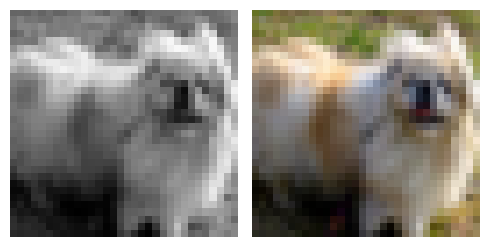

In [8]:
a,b = trn_ds[40]
subplots([a,b], nc=2)

In [10]:
class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

class DownConv(nn.Module):
    def __init__(self, ni, no, maxpool=True):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2) if maxpool else Identity(),
            nn.Conv2d(ni, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no,no,3,padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x):
        return self.model(x)

class UpConv(nn.Module):
    def __init__(self, ni, no, maxpool=True):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(ni, no, 2, stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(no+no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
        )
    def forward(self, x, y):
        x = self.convtranspose(x)
        x = torch.cat([x,y], axis=1)
        x = self.convlayers(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Down-sampling layers
        self.d1 = DownConv(3, 64, maxpool=False)
        self.d2 = DownConv(64, 128)
        self.d3 = DownConv(128, 256)
        self.d4 = DownConv(256, 512)
        self.d5 = DownConv(512, 1024)
        
        # Up-sampling layers
        self.u5 = UpConv(1024, 512)
        self.u4 = UpConv(512, 256)
        self.u3 = UpConv(256, 128)
        self.u2 = UpConv(128, 64)
        
        # Final output layer
        self.u1 = nn.Conv2d(64, 3, kernel_size=1, stride=1)
    
    def forward(self, x):
        # Down-sampling
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        x4 = self.d5(x3)
        
        # Up-sampling
        X4 = self.u5(x4, x3)
        X3 = self.u4(X4, x2)
        X2 = self.u3(X3, x1)
        X1 = self.u2(X2, x0)
        X0 = self.u1(X1)
        
        return X0

In [12]:
from torch import optim

def get_model():
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

def train_batch(model, data, optimizer, criterion):
    model.train()  # Define o modelo para o modo de treinamento
    x, y = data  # Desempacota os dados de entrada (x) e os alvos (y)
    _y = model(x)  # Gera as previsões
    optimizer.zero_grad()  # Limpa os gradientes acumulados anteriormente
    loss = criterion(_y, y)  # Calcula a perda
    loss.backward()  # Calcula os gradientes
    optimizer.step()  # Atualiza os pesos do modelo
    return loss.item()  # Retorna a perda como um escalar

@torch.no_grad()  # Desabilita os cálculos de gradientes
def validate_batch(model, data, criterion):
    model.eval()  # Define o modelo para o modo de avaliação
    x, y = data  # Desempacota os dados de entrada (x) e os alvos (y)
    _y = model(x)  # Gera as previsões
    loss = criterion(_y, y)  # Calcula a perda
    return loss.item()  # Retorna a perda como um escalar


In [ ]:
model, optimizer, criterion = get_model()
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

_val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

n_epochs = 100
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss = train_batch(model, data, optimizer, criterion)
        if(bx+1)%50 == 0:
            for _ in range(5):
                a,b = next(iter(_val_dl))
                _b = model(a)
                subplots([a[0], b[0], _b[0]], nc=3, figsize=(5,5))
    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss = validate_batch(model, data, criterion)
    exp_lr_scheduler.step()
    for _ in range(5):
        a,b = next(iter(_val_dl))
        _b = model(a)
        subplots([a[0],b[0],_b[0]], nc=3, figsize=(5,5))